## Análisis Exploratio de Datos 

### Liberias

In [1]:
# Sistema
import warnings
warnings.filterwarnings("ignore")
import random

# Datos
import pandas as pd
import numpy as np
import re
import ast
from collections import Counter

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, MinMaxScaler

# División de datos y optimización de Modelos
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Guardar Modelo
import joblib

# Configuración de Pandas
pd.set_option('display.max_columns', None)

# Otros (Generación de datos y manipulación de fechas)
from faker import Faker
from datetime import timedelta, datetime

### Carga de datos

In [2]:
fake = Faker('es_ES')
np.random.seed(42)
random.seed(42)

In [3]:
ACTIVIDADES = {
    "ocio": 15,
    "viajes": 30,
    "deportes": 20,
    "salud": 12,
    "educación": 18,
    "cine": 10
}

In [4]:
RANGO_ACTIVIDADES = {
    "ocio": (4, 14),
    "viajes": (6, 14),
    "deportes": (6, 14),
    "salud": (0, 14),
    "educación": (4, 14),
    "cine": (3, 14)
}

In [5]:
def estacion_del_anio(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]:
        return 'Invierno'
    elif mes in [3, 4, 5]:
        return 'Primavera'
    elif mes in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

In [6]:
def generar_datos_sinteticos(fecha_inicio="2021-04-01", fecha_fin="2024-04-01"):
    fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
    registros = []
    regiones = ["Madrid", "Barcelona", "Málaga", "Valencia", "Sevilla", "Zaragoza"]

    for fecha in fechas:
        for _ in range(np.random.randint(20, 40)):
            genero = random.choice(["M", "F"])
            discapacidad = random.choices(
                ["Ninguna", "Sensorial", "Motora", "Cognitiva"],
                weights=[0.85, 0.05, 0.05, 0.05]
            )[0]

            actividad = random.choices(
                list(ACTIVIDADES.keys()),
                weights=[0.20, 0.20, 0.20, 0.15, 0.15, 0.10]
            )[0]

            min_ed, max_ed = RANGO_ACTIVIDADES[actividad]
            edad_min = random.randint(min_ed, max_ed - 1)
            edad_max = random.randint(edad_min + 1, max_ed)
            grupo_edad = f"{edad_min}-{edad_max}"
            edad = random.randint(edad_min, edad_max)

            base = ACTIVIDADES[actividad]
            variacion = np.random.normal(0, 3)
            ajuste_edad = 1.1 if edad >= 10 else 1.0
            gasto = max(5, round((base + variacion) * ajuste_edad, 2))

            registros.append({
                "fecha": fecha,
                "edad": edad,
                "genero": genero,
                "discapacidad": discapacidad,
                "actividad": actividad,
                "region": random.choice(regiones),
                "gasto": gasto,
                "estacion": estacion_del_anio(fecha),
                "edad_minima": edad_min,
                "edad_maxima": edad_max,
                "grupo_edad": grupo_edad
            })

    return pd.DataFrame(registros)

In [7]:
df = generar_datos_sinteticos()

In [ ]:
#df.to_csv("datos_sinteticos_madrid_03.csv", index=False, encoding='utf-8')

In [8]:
file_path = r"C:\Users\garci\Desktop\Proyecto\Data\datos_sinteticos_madrid_03.csv"
df = pd.read_csv(file_path)
df

,fecha,edad,genero,discapacidad,actividad,region,gasto,estacion,edad_minima,edad_maxima,grupo_edad
0,2021-04-01,11,M,Ninguna,viajes,Madrid,31.18,Primavera,9,11,9-11
1,2021-04-01,6,M,Ninguna,ocio,Sevilla,16.55,Primavera,5,9,5-9
2,2021-04-01,14,M,Ninguna,salud,Barcelona,14.76,Primavera,11,14,11-14
3,2021-04-01,7,F,Ninguna,educación,Málaga,22.11,Primavera,4,7,4-7
4,2021-04-01,8,F,Ninguna,cine,Valencia,7.25,Primavera,8,9,8-9
...,...,...,...,...,...,...,...,...,...,...,...
32555,2024-04-01,12,F,Ninguna,viajes,Barcelona,32.45,Primavera,12,13,12-13
32556,2024-04-01,13,M,Ninguna,deportes,Zaragoza,21.64,Primavera,13,14,13-14
32557,2024-04-01,14,F,Ninguna,viajes,Valencia,34.98,Primavera,13,14,13-14
32558,2024-04-01,8,F,Ninguna,educación,Madrid,23.10,Primavera,4,10,4-10


### Exploración inicial de datos

In [9]:
exploration = pd.DataFrame({'Valores nulos': df.isnull().sum(), 'Porcentaje (%)': round((df.isnull().sum() / df.shape[0]) * 100, 2), 'Tipo de dato': df.dtypes, 'Valores únicos': df.nunique(), 'Valor más frecuente': df.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None), 'Es numérica': df.apply(pd.api.types.is_numeric_dtype)}).reset_index().rename(columns={'index': 'Columna'}).sort_index().assign(**{'Total columnas': len(df.columns)})
exploration

,Columna,Valores nulos,Porcentaje (%),Tipo de dato,Valores únicos,Valor más frecuente,Es numérica,Total columnas
0,fecha,0,0.0,object,1097,2021-04-17,False,11
1,edad,0,0.0,int64,15,13,True,11
2,genero,0,0.0,object,2,M,False,11
3,discapacidad,0,0.0,object,4,Ninguna,False,11
4,actividad,0,0.0,object,6,deportes,False,11
5,region,0,0.0,object,6,Zaragoza,False,11
6,gasto,0,0.0,float64,3453,5.0,True,11
7,estacion,0,0.0,object,4,Primavera,False,11
8,edad_minima,0,0.0,int64,14,7,True,11
9,edad_maxima,0,0.0,int64,14,14,True,11


In [10]:
duplicados_total = pd.DataFrame({'Total duplicados': [df.duplicated().sum()], 'Porcentaje (%)': [round(df.duplicated().sum() / df.shape[0] * 100, 2)]})
duplicados_total

,Total duplicados,Porcentaje (%)
0,0,0.0


In [11]:
estadisticas_df = df.describe().T
print("\n Estadísticas numéricas:")
display(estadisticas_df)


 Estadísticas numéricas:


,count,mean,std,min,25%,50%,75%,max
edad,32560.0,10.116923,2.832441,0.0,8.00,11.00,12.00,14.00
gasto,32560.0,19.695153,7.823584,5.0,13.91,18.43,24.17,46.01
edad_minima,32560.0,8.507156,3.086986,0.0,6.00,9.00,11.00,13.00
edad_maxima,32560.0,11.747328,2.369272,1.0,10.00,12.00,14.00,14.00


In [12]:
frecuencia_categorias_df = pd.DataFrame.from_dict(
    {col: df[col].value_counts().head(10) for col in df.select_dtypes(include='object').columns},
    orient='index'
).T
frecuencia_categorias_df

,fecha,genero,discapacidad,actividad,region,estacion,grupo_edad
2021-11-02,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-15,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-22,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-28,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-24,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-24,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-09,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-19,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-18,39.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-18,39.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
agrupado = df.groupby(['grupo_edad', 'estacion']).agg({
    'gasto': ['mean', 'count'],
    'actividad': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()
agrupado.columns = ['grupo_edad', 'estacion', 'gasto_medio', 'num_registros', 'actividad_mas_comun']
agrupado

,grupo_edad,estacion,gasto_medio,num_registros,actividad_mas_comun
0,0-1,Invierno,12.336667,3,salud
1,0-1,Otoño,11.492000,5,salud
2,0-1,Primavera,11.401429,7,salud
3,0-1,Verano,12.243333,3,salud
4,0-10,Invierno,11.474444,9,salud
...,...,...,...,...,...
415,9-13,Verano,22.522113,142,viajes
416,9-14,Invierno,20.778986,148,viajes
417,9-14,Otoño,20.542165,194,viajes
418,9-14,Primavera,21.618412,170,viajes


Este análisis se ha realizado sobre un conjunto de datos sintéticos generados entre 2021 y 2024, correspondientes a actividades realizadas por niños y niñas de 0 a 14 años en diversas regiones de España. A continuación se presenta un resumen general del estado del dataset.

---

## Información General del Dataset

- **Número total de registros:** 32,560
- **Número total de columnas:** 11

### Estado de los datos

- **Valores nulos:** 0 en todas las columnas
- **Duplicados:** 0 registros duplicados exactos

---

## Exploración General de Columnas

| Columna         | Tipo     | Valores Únicos | Valor Más Frecuente | Es Numérica |
|-----------------|----------|----------------|----------------------|-------------|
| `fecha`         | object   | 1,097          | 2021-04-17           | No          |
| `edad`          | int64    | 15             | 13                   | Sí          |
| `genero`        | object   | 2              | M                    | No          |
| `discapacidad`  | object   | 4              | Ninguna              | No          |
| `actividad`     | object   | 6              | deportes             | No          |
| `region`        | object   | 6              | Zaragoza             | No          |
| `gasto`         | float64  | 3,453          | 5.0                  | Sí          |
| `estacion`      | object   | 4              | Primavera            | No          |
| `edad_minima`   | int64    | 14             | 7                    | Sí          |
| `edad_maxima`   | int64    | 14             | 14                   | Sí          |
| `grupo_edad`    | object   | 105            | 13-14                | No          |

---

## Estadísticas Numéricas

| Variable       | Media    | Mínimo | Máximo | Mediana | Desv. Est. |
|----------------|----------|--------|--------|---------|------------|
| `edad`         | 10.12    | 0      | 14     | 11.00   | 2.83       |
| `gasto (€)`    | 19.70    | 5.00   | 46.01  | 18.43   | 7.82       |
| `edad_minima`  | 8.51     | 0      | 13     | 9.00    | 3.09       |
| `edad_maxima`  | 11.75    | 1      | 14     | 12.00   | 2.37       |

---

## Frecuencia de Variables Categóricas

| Variable      | Valores más comunes (Top 3)         |
|---------------|-------------------------------------|
| `genero`      | M (16,464), F (16,096)              |
| `discapacidad`| Ninguna, Cognitiva, Sensorial       |
| `actividad`   | deportes, viajes, ocio              |
| `region`      | Zaragoza, Valencia, Barcelona       |
| `estacion`    | Primavera, Otoño, Verano            |
| `grupo_edad`  | 13-14, 12-13, 12-14                 |

---

## Gasto Medio por Grupo de Edad y Estación

A continuación se presenta un extracto del análisis por grupo de edad y estación:

| Grupo Edad | Estación   | Gasto Medio (€) | Registros | Actividad Más Común |
|------------|------------|------------------|-----------|----------------------|
| 0-1        | Invierno   | 12.34            | 3         | salud                |
| 0-1        | Otoño      | 11.49            | 5         | salud                |
| 0-1        | Primavera  | 11.40            | 7         | salud                |
| 9-14       | Verano     | 22.01            | 171       | viajes               |

---

## Conclusiones Iniciales

- El dataset está limpio, sin valores nulos ni duplicados.
- Las variables categóricas están bien distribuidas, aunque ciertas categorías como `actividad` y `grupo_edad` tienen muchos niveles.
- El grupo de edad más frecuente es 13-14 y las actividades más comunes son deportes, viajes y ocio.
- Existen diferencias de gasto por grupo etario y estación, siendo los mayores (9-14) quienes generan mayores gastos promedio.


### Limpieza y transformación

In [14]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['gasto'] = df['gasto'].astype(float)

In [15]:
df['dia_semana'] = df['fecha'].dt.day_name()
df['mes'] = df['fecha'].dt.month
df['anio'] = df['fecha'].dt.year

In [16]:
df_encoded = df.copy()
label_cols = ['genero', 'discapacidad', 'actividad', 'estacion', 'grupo_edad', 'dia_semana']
encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_encoded[col + "_enc"] = le.fit_transform(df[col])
    encoders[col] = le

In [17]:
agg_edad_estacion = df.groupby(['grupo_edad', 'estacion']).agg({
    'gasto': ['mean', 'count'],
    'actividad': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()

agg_edad_estacion.columns = ['grupo_edad', 'estacion', 'gasto_medio', 'num_registros', 'actividad_mas_comun']

In [18]:
features_regresion = df_encoded[[
    'edad', 'genero_enc', 'discapacidad_enc', 'actividad_enc',
    'estacion_enc', 'grupo_edad_enc', 'dia_semana_enc', 'mes'
]]
target_regresion = df_encoded['gasto']

features_clasificacion = df_encoded[[
    'edad', 'genero_enc', 'discapacidad_enc',
    'estacion_enc', 'grupo_edad_enc', 'dia_semana_enc', 'mes'
]]
target_clasificacion = df_encoded['actividad_enc']

In [19]:
df_encoded.to_csv("datos_procesados_para_modelo.csv", index=False)

In [20]:
df_encoded

,fecha,edad,genero,discapacidad,actividad,region,gasto,estacion,edad_minima,edad_maxima,grupo_edad,dia_semana,mes,anio,genero_enc,discapacidad_enc,actividad_enc,estacion_enc,grupo_edad_enc,dia_semana_enc
0,2021-04-01,11,M,Ninguna,viajes,Madrid,31.18,Primavera,9,11,9-11,Thursday,4,2021,1,2,5,2,101,4
1,2021-04-01,6,M,Ninguna,ocio,Sevilla,16.55,Primavera,5,9,5-9,Thursday,4,2021,1,2,3,2,78,4
2,2021-04-01,14,M,Ninguna,salud,Barcelona,14.76,Primavera,11,14,11-14,Thursday,4,2021,1,2,4,2,33,4
3,2021-04-01,7,F,Ninguna,educación,Málaga,22.11,Primavera,4,7,4-7,Thursday,4,2021,0,2,2,2,67,4
4,2021-04-01,8,F,Ninguna,cine,Valencia,7.25,Primavera,8,9,8-9,Thursday,4,2021,0,2,0,2,99,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,2024-04-01,12,F,Ninguna,viajes,Barcelona,32.45,Primavera,12,13,12-13,Monday,4,2024,0,2,5,2,34,1
32556,2024-04-01,13,M,Ninguna,deportes,Zaragoza,21.64,Primavera,13,14,13-14,Monday,4,2024,1,2,1,2,36,1
32557,2024-04-01,14,F,Ninguna,viajes,Valencia,34.98,Primavera,13,14,13-14,Monday,4,2024,0,2,5,2,36,1
32558,2024-04-01,8,F,Ninguna,educación,Madrid,23.10,Primavera,4,10,4-10,Monday,4,2024,0,2,2,2,60,1


Se realizaron los siguientes pasos para preparar el dataset con fines de modelado predictivo:

- **Conversión de fechas**: Se transformó la columna `fecha` al tipo `datetime`, y se derivaron nuevas variables temporales:
  - `dia_semana`: día de la semana
  - `mes`: mes numérico
  - `anio`: año

- **Conversión de tipo**: Se aseguró que la variable `gasto` estuviera en formato numérico flotante (`float`).

- **Codificación de variables categóricas**: 
  Se aplicó `LabelEncoder` a las siguientes columnas para convertirlas en variables numéricas:
  - `genero` → `genero_enc`
  - `discapacidad` → `discapacidad_enc`
  - `actividad` → `actividad_enc`
  - `estacion` → `estacion_enc`
  - `grupo_edad` → `grupo_edad_enc`
  - `dia_semana` → `dia_semana_enc`

- **Construcción del dataset final**:
  Se creó un DataFrame codificado llamado `df_encoded`, el cual incluye tanto las variables originales como sus versiones codificadas.

- **Definición de variables para modelos**:
  - Para regresión (`target = gasto`): se seleccionaron variables como edad, género, discapacidad, actividad, estación, grupo de edad, día de la semana y mes.
  - Para clasificación (`target = actividad_enc`): se excluyó `actividad_enc` como entrada y se usaron el resto de atributos codificados.

Este conjunto preparado y transformado sirvió como base para el entrenamiento de los modelos de machine learning.

### Gráficos

In [21]:
sns.set(style="whitegrid")
azul = "#1f77b4"
naranja = "#ff7f0e"
def agrupar_grupo_general(grupo):
    try:
        min_edad = int(grupo.split('-')[0])
        if 0 <= min_edad <= 3:
            return '0-3'
        elif 4 <= min_edad <= 6:
            return '4-6'
        elif 7 <= min_edad <= 9:
            return '7-9'
        elif 10 <= min_edad <= 12:
            return '10-12'
        elif 13 <= min_edad <= 14:
            return '13-14'
        else:
            return 'Otro'
    except:
        return 'Otro'

df['grupo_general'] = df['grupo_edad'].apply(agrupar_grupo_general)
orden_grupos = ['0-3', '4-6', '7-9', '10-12', '13-14']

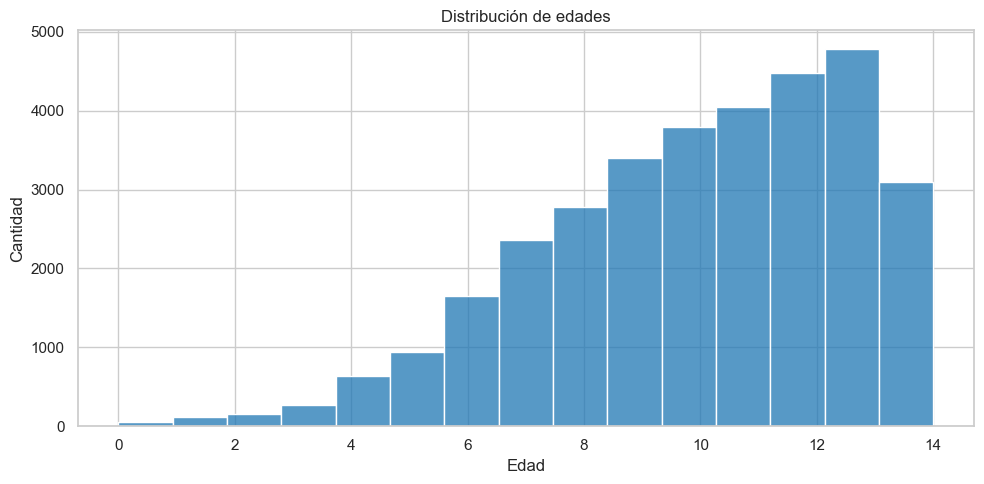

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='edad', bins=15, color=azul)
plt.title("Distribución de edades")
plt.xlabel("Edad")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

### Distribución de edades

**Descripción**  
Histograma que muestra la frecuencia de edades en la muestra, desde los 0 hasta los 14 años.

**Análisis**  
Se observa un crecimiento progresivo en la frecuencia de niños conforme aumenta la edad, alcanzando su punto máximo en los 12 años. Este patrón sugiere que la mayoría de los registros corresponden a niños de mayor edad dentro del rango permitido por el dataset.

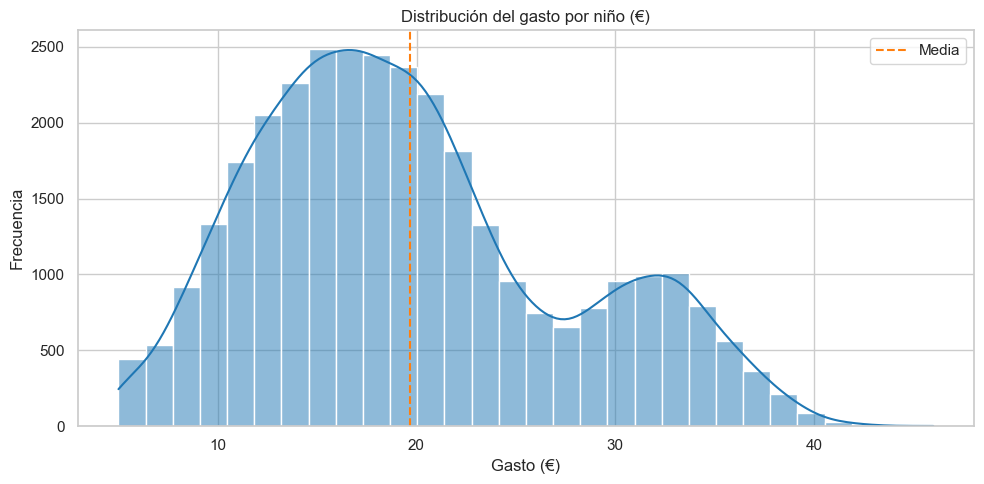

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(df['gasto'], bins=30, kde=True, color=azul)
plt.axvline(df['gasto'].mean(), color=naranja, linestyle='--', label='Media')
plt.title("Distribución del gasto por niño (€)")
plt.xlabel("Gasto (€)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

### Distribución del gasto por niño (€)

**Descripción**  
Histograma con curva KDE que ilustra cómo se distribuyen los valores de gasto individual, junto a una línea punteada que representa la media general.

**Análisis**  
La distribución es bimodal, con una gran concentración entre los 10 y 20 €, y otra más dispersa entre los 25 y 35 €. Esto sugiere la existencia de al menos dos tipos de comportamiento de gasto, probablemente asociados al tipo de actividad o grupo etario.

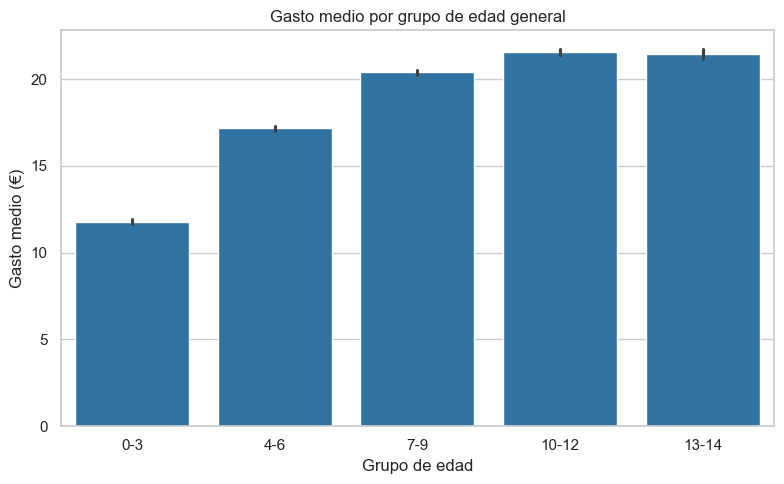

In [26]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='grupo_general', y='gasto', order=orden_grupos, estimator=np.mean, color=azul)
plt.title("Gasto medio por grupo de edad general")
plt.xlabel("Grupo de edad")
plt.ylabel("Gasto medio (€)")
plt.tight_layout()
plt.show()

### Gasto medio por grupo de edad general

**Descripción**  
Gráfico de barras que muestra el promedio del gasto por grupo etario general (de 0 a 14 años).

**Análisis**  
Se detecta un incremento consistente del gasto medio conforme aumenta el grupo de edad. Los grupos 10–12 y 13–14 registran los mayores promedios, lo cual puede relacionarse con actividades más costosas en etapas mayores de la niñez.

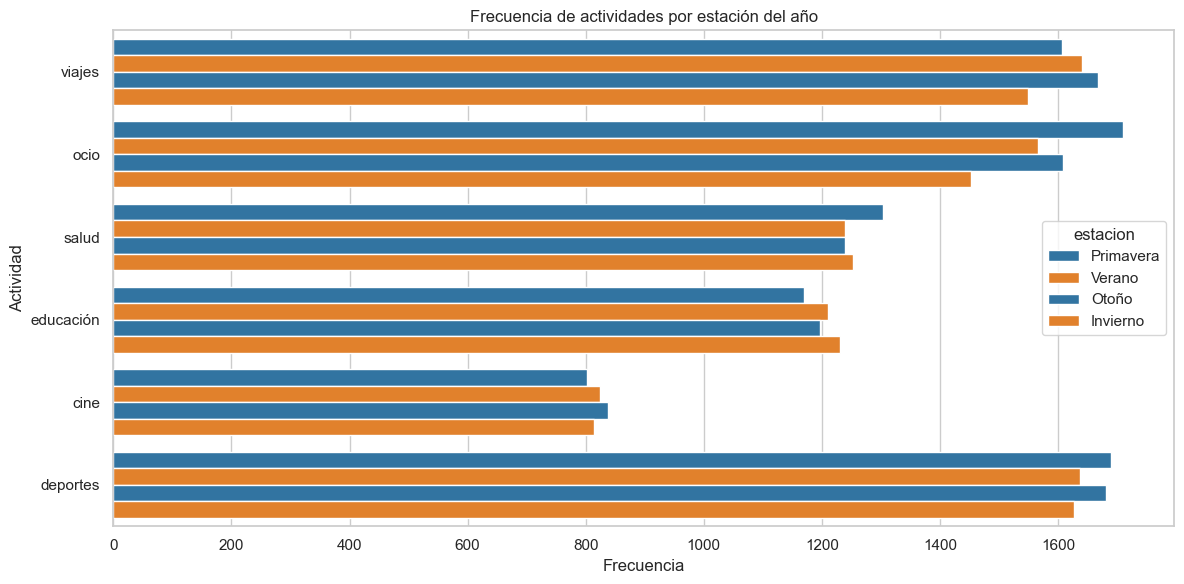

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='actividad', hue='estacion', palette=[azul, naranja])
plt.title("Frecuencia de actividades por estación del año")
plt.xlabel("Frecuencia")
plt.ylabel("Actividad")
plt.tight_layout()
plt.show()

### Frecuencia de actividades por estación del año

**Descripción**  
Gráfico de barras horizontales agrupadas por estación que muestra cuántas veces se registra cada tipo de actividad a lo largo de las cuatro estaciones.

**Análisis**  
Las actividades más populares como deportes y viajes tienen alta frecuencia en todas las estaciones, destacando primavera y verano. Cine y salud presentan menor frecuencia, especialmente en estaciones cálidas.


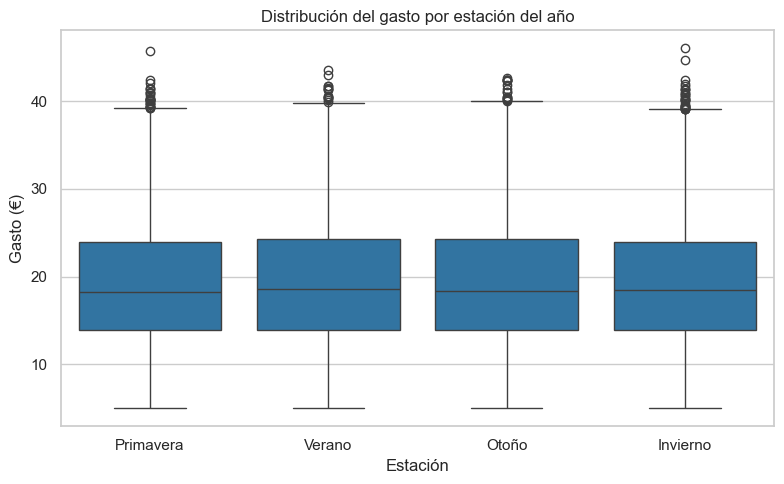

In [28]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='estacion', y='gasto', color=azul)
plt.title("Distribución del gasto por estación del año")
plt.xlabel("Estación")
plt.ylabel("Gasto (€)")
plt.tight_layout()
plt.show()

### Distribución del gasto por estación del año

**Descripción**  
Boxplot que visualiza la dispersión del gasto según las estaciones del año: primavera, verano, otoño e invierno.

**Análisis**  
El gasto mediano es relativamente estable entre estaciones, aunque verano y primavera muestran una ligera tendencia a valores más altos. También se aprecian varios valores atípicos, indicando familias con gastos considerablemente mayores.


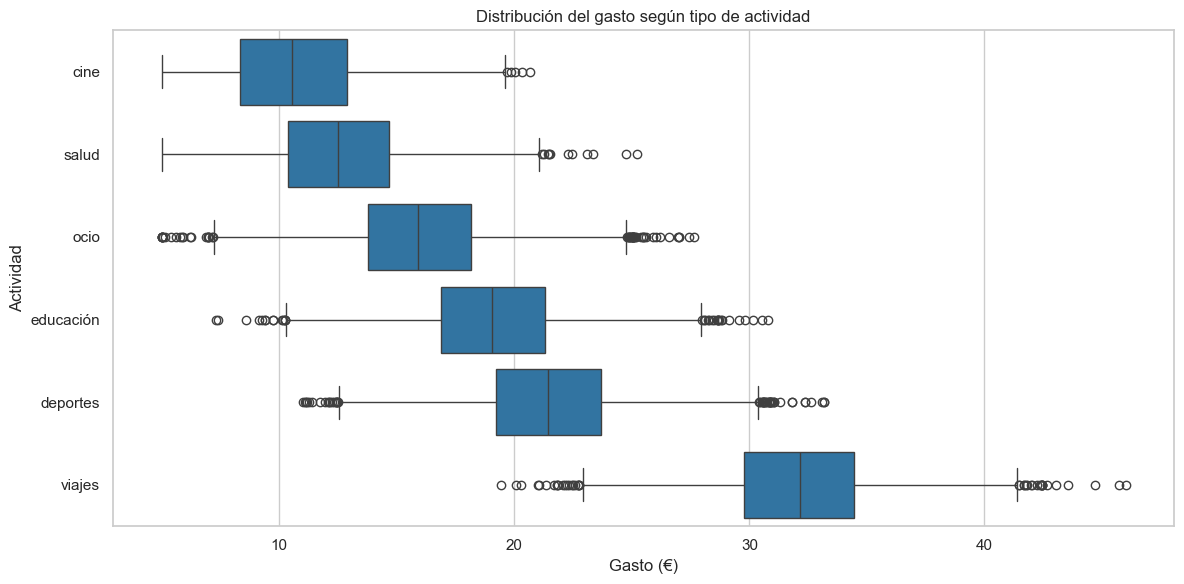

In [29]:
plt.figure(figsize=(12, 6))
orden_actividades = df.groupby('actividad')['gasto'].median().sort_values().index
sns.boxplot(data=df, x='gasto', y='actividad', order=orden_actividades, color=azul)
plt.title("Distribución del gasto según tipo de actividad")
plt.xlabel("Gasto (€)")
plt.ylabel("Actividad")
plt.tight_layout()
plt.show()

### Distribución del gasto según tipo de actividad

**Descripción**  
Boxplot que compara la distribución del gasto entre las distintas categorías de actividad.

**Análisis**  
Actividades como viajes y deportes tienen el gasto más elevado y disperso, mientras que salud y cine concentran los menores niveles de gasto. Esto indica una variabilidad importante en el coste de las actividades ofertadas.

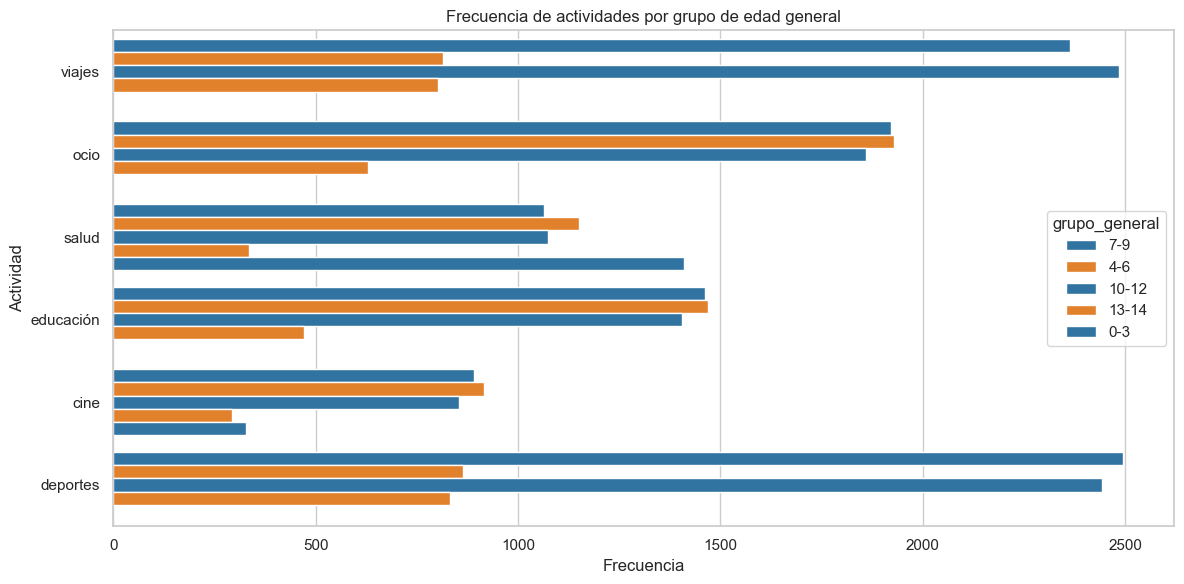

In [30]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='actividad', hue='grupo_general', palette=[azul, naranja])
plt.title("Frecuencia de actividades por grupo de edad general")
plt.xlabel("Frecuencia")
plt.ylabel("Actividad")
plt.tight_layout()
plt.show()

### Frecuencia de actividades por grupo de edad general

**Descripción**  
Gráfico de barras horizontales agrupadas por grupo de edad general, mostrando cuántas veces participan en cada tipo de actividad.

**Análisis**  
Los niños entre 7 y 12 años participan más en actividades como viajes y deportes. Los grupos más pequeños (0–3 y 4–6) se inclinan por actividades como salud y ocio, lo que refleja un patrón de elección ligado al desarrollo.

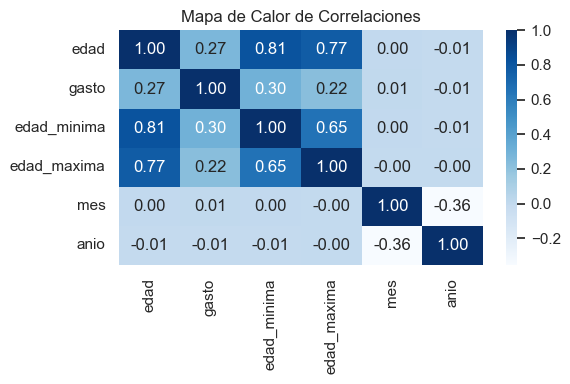

In [31]:
plt.figure(figsize=(6, 4))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Mapa de Calor de Correlaciones")
plt.tight_layout()
plt.show()

### Mapa de calor de correlaciones

**Descripción**  
Heatmap de correlaciones entre variables numéricas del conjunto de datos.

**Análisis**  
Existe una fuerte correlación entre edad y las variables edad_mínima y edad_maxima, lo cual es lógico. También se detecta una relación positiva moderada entre edad y gasto, lo que refuerza hallazgos anteriores sobre los grupos mayores con mayor inversión.


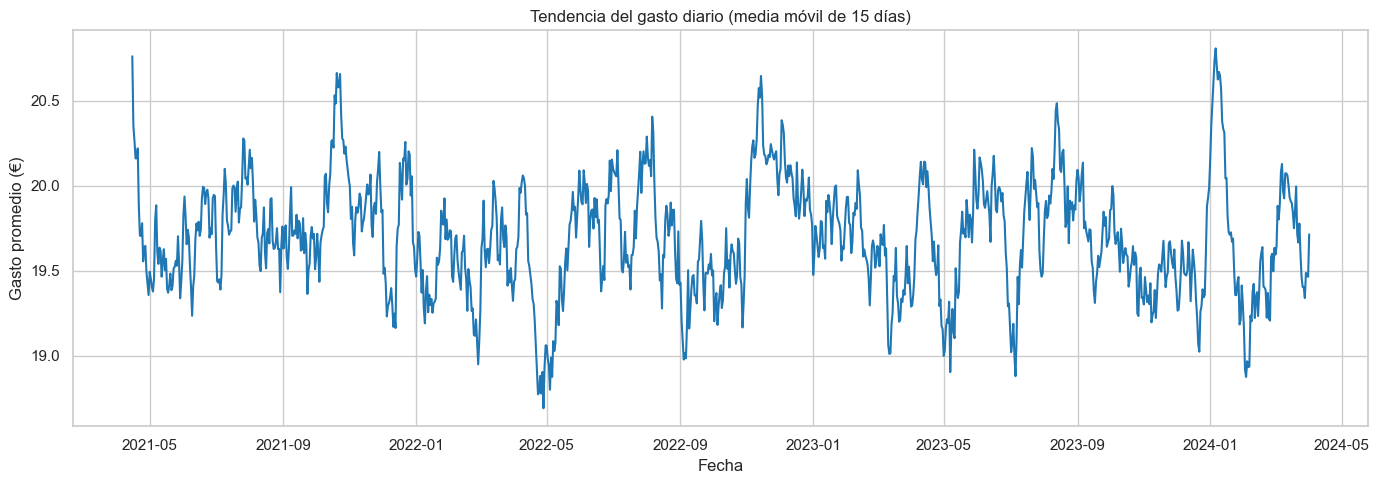

In [32]:
df_gasto_tendencia = df.groupby('fecha')['gasto'].mean().rolling(window=15).mean().reset_index()
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_gasto_tendencia, x='fecha', y='gasto', color=azul)
plt.title("Tendencia del gasto diario (media móvil de 15 días)")
plt.xlabel("Fecha")
plt.ylabel("Gasto promedio (€)")
plt.tight_layout()
plt.show()

### Tendencia del gasto diario (media móvil de 15 días)

**Descripción**  
Gráfico de líneas que muestra la evolución del gasto promedio diario a lo largo del tiempo, suavizado con una media móvil de 15 días.

**Análisis**  
Se detectan ciclos repetitivos anuales, con incrementos notables de gasto en los meses cálidos y bajones en los primeros meses del año. Esto sugiere una estacionalidad clara que debe ser tenida en cuenta para predicciones futuras.

### Machine Learning

### Objetivo
Predecir el gasto en euros (€) que una familia realizará por niño en función de características como la edad, género, estación del año y tipo de actividad, entre otras.  
El enfoque está dirigido a estimar el **gasto medio por tipo de actividad** para los próximos **15 días**, considerando todas las regiones disponibles, incluyendo pero no limitándose a la Comunidad de Madrid.

---

### Tipo de Problema
Se trata de un problema de **regresión supervisada**, ya que:

- La variable a predecir (`gasto`) es numérica y continua.
- El modelo se entrena con datos históricos que contienen tanto las variables predictoras como la variable objetivo.

---

### Variables Predictoras (Features)

- `edad`: Edad del niño o niña.
- `genero_enc`: Género codificado (0 = F, 1 = M).
- `discapacidad_enc`: Tipo de discapacidad codificada.
- `actividad_enc`: Tipo de actividad codificada (ocio, viajes, deportes, salud, educación, cine).
- `estacion_enc`: Estación del año codificada.
- `grupo_edad_enc`: Grupo de edad codificado (ej. 0–3, 4–6...).
- `dia_semana_enc`: Día de la semana codificado (lunes a domingo).
- `mes`: Mes del año (1 a 12).

---

### Variable Objetivo

- `gasto`: Monto en euros que una familia gasta por niño según la actividad realizada.

---

### Métricas de Evaluación

| Métrica | Nombre completo                  | Qué mide                                               | Objetivo           |
|---------|----------------------------------|---------------------------------------------------------|--------------------|
| MAE     | Error absoluto medio             | Promedio de los errores absolutos                      | Minimizar          |
| RMSE    | Raíz del error cuadrático medio  | Penaliza más los errores grandes                       | Minimizar          |
| R²      | Coeficiente de determinación     | Cuantifica qué tan bien el modelo explica la varianza | Maximizar          |


### Modelos de Predicción

In [33]:
X = df_encoded[[
    'edad', 'genero_enc', 'discapacidad_enc', 'actividad_enc',
    'estacion_enc', 'grupo_edad_enc', 'dia_semana_enc', 'mes'
]]
y = df_encoded['gasto']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Tamaño de X       :", X.shape)
print("Tamaño de X_train :", X_train.shape)
print("Tamaño de X_test  :", X_test.shape)
print("Tamaño de y_train :", y_train.shape)
print("Tamaño de y_test  :", y_test.shape)

Tamaño de X       : (32560, 8)
Tamaño de X_train : (26048, 8)
Tamaño de X_test  : (6512, 8)
Tamaño de y_train : (26048,)
Tamaño de y_test  : (6512,)


### Regresión Lineal 

### KNN

In [35]:
modelo_knn = KNeighborsRegressor()
modelo_knn.fit(X_train, y_train)
y_pred_knn = modelo_knn.predict(X_test)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print("KNeighbors Regressor - Resultados:")
print(f"MAE  : {mae_knn:.4f}")
print(f"RMSE : {rmse_knn:.4f}")
print(f"R²   : {r2_knn:.4f}")

KNeighbors Regressor - Resultados:
MAE  : 3.7399
RMSE : 4.8773
R²   : 0.6016


### DecisionTreeRegressor

In [36]:
modelo_dt = DecisionTreeRegressor(random_state=42)
modelo_dt.fit(X_train, y_train)
y_pred_dt = modelo_dt.predict(X_test)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Regressor - Resultados:")
print(f"MAE  : {mae_dt:.4f}")
print(f"RMSE : {rmse_dt:.4f}")
print(f"R²   : {r2_dt:.4f}")


Decision Tree Regressor - Resultados:
MAE  : 3.6419
RMSE : 4.5695
R²   : 0.6503


### Random Forest Regressor

In [37]:
modelo_rf = RandomForestRegressor(random_state=42)
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor - Resultados:")
print(f"MAE  : {mae_rf:.4f}")
print(f"RMSE : {rmse_rf:.4f}")
print(f"R²   : {r2_rf:.4f}")

Random Forest Regressor - Resultados:
MAE  : 2.7767
RMSE : 3.4762
R²   : 0.7976


### XGBoost Regressor

In [38]:
modelo_xgb = XGBRegressor(random_state=42, verbosity=0)
modelo_xgb.fit(X_train, y_train)
y_pred_xgb = modelo_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor - Resultados:")
print(f"MAE  : {mae_xgb:.4f}")
print(f"RMSE : {rmse_xgb:.4f}")
print(f"R²   : {r2_xgb:.4f}")

XGBoost Regressor - Resultados:
MAE  : 2.5916
RMSE : 3.2464
R²   : 0.8235


In [39]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

param_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

random_search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_xgb,
    n_iter=30,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost - Optimizado:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

XGBoost - Optimizado:
MAE  : 2.5228
RMSE : 3.1585
R²   : 0.8329


### Comparación de los Modelos

| Modelo                    | MAE     | RMSE    | R²     |
|---------------------------|---------|---------|--------|
| Regresión Lineal          | 5.4219  | 6.5019  | 0.2919 |
| KNeighbors Regressor      | 3.7399  | 4.8773  | 0.6016 |
| Decision Tree Regressor   | 3.6419  | 4.5695  | 0.6503 |
| Random Forest Regressor   | 2.7767  | 3.4762  | 0.7976 |
| XGBoost Regressor         | 2.5916  | 3.2464  | 0.8235 |
| **XGBoost Optimizado**    | **2.5228** | **3.1585** | **0.8329** |

---

### Análisis Comparativo

- **MAE** (Error Absoluto Medio): el modelo optimizado de XGBoost presenta el menor error absoluto promedio, lo que indica una mejor aproximación a los valores reales.
- **RMSE** (Raíz del Error Cuadrático Medio): nuevamente, el modelo optimizado ofrece el mejor resultado, penalizando menos los errores grandes.
- **R²** (Coeficiente de Determinación): el modelo optimizado explica aproximadamente el **83%** de la varianza de los datos, el mayor entre todos los modelos probados.

---

### Conclusión

El modelo seleccionado es **XGBoost Optimizado**, ya que presenta el mejor desempeño general en todas las métricas clave. Su capacidad para manejar relaciones no lineales, ajustar múltiples hiperparámetros y mantener una baja tasa de error lo convierten en la mejor opción para predecir con precisión el gasto por niño en actividades durante los próximos días.


### Guardar el modelo

In [ ]:
#import joblib
#joblib.dump(best_xgb, "modelo_xgboost_optimizado.joblib")
#print("Modelo guardado como 'modelo_xgboost_optimizado.joblib'")

In [42]:
# Cargar el modelo desde el archivo
# modelo_cargado = joblib.load("modelo_xgboost_optimizado.joblib")

### Evaluación y prueba del modelo

### Objetivo
Probar el rendimiento del modelo XGBoost optimizado en condiciones reales simuladas, generando predicciones del gasto medio por actividad durante los próximos 15 días en varias regiones.


In [40]:
modelo = joblib.load("modelo_xgboost_optimizado.joblib")

fechas_futuras = pd.date_range(start=datetime.today(), periods=15)

regiones = ['Madrid', 'Barcelona', 'Valencia', 'Sevilla', 'Málaga', 'Zaragoza']
actividades = ['ocio', 'viajes', 'deportes', 'salud', 'educación', 'cine']

enc_actividad = LabelEncoder()
enc_actividad.fit(actividades)

dias_semana_dict = {
    'monday': 0, 'tuesday': 1, 'wednesday': 2, 'thursday': 3,
    'friday': 4, 'saturday': 5, 'sunday': 6
}

registros = []
for fecha in fechas_futuras:
    for region in regiones:
        for actividad in actividades:
            edad = np.random.randint(0, 15)
            genero_enc = np.random.randint(0, 2)
            discapacidad_enc = np.random.randint(0, 4)

            estacion = (
                'Invierno' if fecha.month in [12, 1, 2] else
                'Primavera' if fecha.month in [3, 4, 5] else
                'Verano' if fecha.month in [6, 7, 8] else
                'Otoño'
            )

            grupo = (
                '0-3' if edad <= 3 else
                '3-5' if edad <= 5 else
                '6-8' if edad <= 8 else
                '9-11' if edad <= 11 else
                '12-14'
            )

            estacion_enc = {'Invierno': 0, 'Primavera': 1, 'Verano': 2, 'Otoño': 3}[estacion]
            grupo_edad_enc = {'0-3': 0, '3-5': 1, '6-8': 2, '9-11': 3, '12-14': 4}[grupo]
            dia_ingles = fecha.strftime("%A").lower()
            dia_semana_enc = dias_semana_dict[dia_ingles]
            actividad_enc = enc_actividad.transform([actividad])[0]

            X_new = [[
                edad, genero_enc, discapacidad_enc, actividad_enc,
                estacion_enc, grupo_edad_enc, dia_semana_enc, fecha.month
            ]]

            gasto_predicho = modelo.predict(X_new)[0]

            registros.append({
                'fecha': fecha.date(),
                'region': region,
                'actividad': actividad,
                'gasto_predicho': round(gasto_predicho, 2)
            })

df_predicciones = pd.DataFrame(registros)
print(df_predicciones.head(10))


        fecha     region  actividad  gasto_predicho
0  2025-05-06     Madrid       ocio           14.90
1  2025-05-06     Madrid     viajes           10.76
2  2025-05-06     Madrid   deportes           13.43
3  2025-05-06     Madrid      salud            8.03
4  2025-05-06     Madrid  educación           20.27
5  2025-05-06     Madrid       cine           17.27
6  2025-05-06  Barcelona       ocio           15.42
7  2025-05-06  Barcelona     viajes            9.87
8  2025-05-06  Barcelona   deportes           13.07
9  2025-05-06  Barcelona      salud            9.26


In [42]:
df_predicciones.to_csv("prediccion_15dias_xgboost.csv", index=False, encoding='utf-8')
print("Archivo guardado como 'prediccion_15dias_xgboost.csv'")

Archivo guardado como 'prediccion_15dias_xgboost.csv'


In [49]:
df_pred = pd.read_csv("prediccion_15dias_xgboost.csv")
df_pred['fecha'] = pd.to_datetime(df_pred['fecha'])

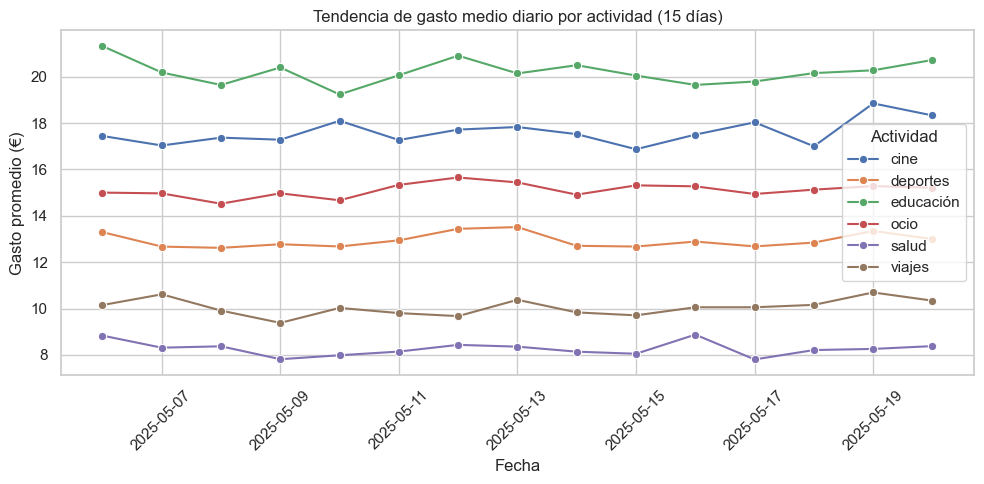

In [50]:
plt.figure()
sns.lineplot(data=df_pred.groupby(['fecha', 'actividad'])['gasto_predicho'].mean().reset_index(),
             x='fecha', y='gasto_predicho', hue='actividad', marker='o')
plt.title("Tendencia de gasto medio diario por actividad (15 días)")
plt.xlabel("Fecha")
plt.ylabel("Gasto promedio (€)")
plt.legend(title="Actividad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Tendencia de gasto medio diario por actividad (15 días)

**Descripción**  
Este gráfico de líneas muestra la evolución diaria del gasto promedio previsto para cada tipo de actividad durante los próximos 15 días. Se desglosa por actividad: cine, deportes, educación, ocio, salud y viajes.

**Análisis**  
Se observa una notable estabilidad en las tendencias de gasto por actividad. Educación mantiene consistentemente el gasto más elevado, seguida por cine y ocio. Salud y viajes se mantienen como las actividades con menor gasto previsto. La escasa variación entre días respalda la consistencia del modelo y su capacidad para capturar patrones estacionales de corto plazo.

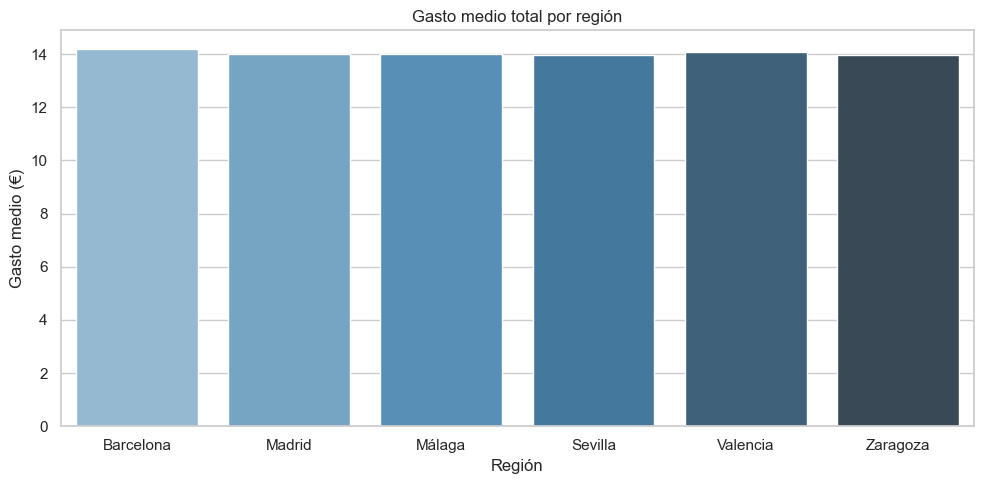

In [51]:
plt.figure()
sns.barplot(data=df_pred.groupby('region')['gasto_predicho'].mean().reset_index(),
            x='region', y='gasto_predicho', palette="Blues_d")
plt.title("Gasto medio total por región")
plt.xlabel("Región")
plt.ylabel("Gasto medio (€)")
plt.tight_layout()
plt.show()

### Gasto medio total por región

**Descripción**  
Gráfico de barras que representa el gasto medio previsto por niño en cada una de las regiones analizadas: Madrid, Barcelona, Valencia, Sevilla, Málaga y Zaragoza.

**Análisis**  
Las diferencias regionales en el gasto son mínimas, lo que indica una distribución bastante homogénea. Esto sugiere que el factor geográfico, aunque incluido, no introduce una variabilidad significativa en el modelo para el horizonte temporal considerado.

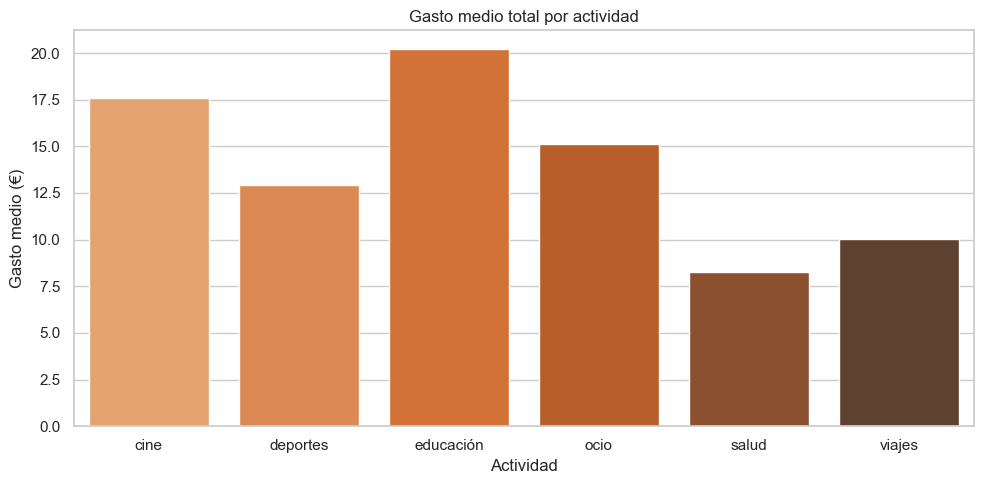

In [52]:
plt.figure()
sns.barplot(data=df_pred.groupby('actividad')['gasto_predicho'].mean().reset_index(),
            x='actividad', y='gasto_predicho', palette="Oranges_d")
plt.title("Gasto medio total por actividad")
plt.xlabel("Actividad")
plt.ylabel("Gasto medio (€)")
plt.tight_layout()
plt.show()

### Gasto medio total por actividad

**Descripción**  
Este gráfico de barras muestra el gasto medio total por actividad en todo el período de predicción.

**Análisis**  
Educación lidera en gasto promedio, lo cual es coherente con la naturaleza de estas actividades, que suelen tener mayores costes asociados. Le siguen cine y ocio, mientras que salud y viajes tienen los menores gastos promedio. Este patrón confirma que el modelo diferencia adecuadamente el coste relativo de las actividades y asigna valores acordes al comportamiento observado durante el entrenamiento.
